## Описание задачи, никнейм на Kaggle, импорт библиотек, константы, загрузка данных

Описание задачи: предсказание рейтинга шоколада от 1 до 5 (регрессия), метрика - $R^{2}$

Описание данных:
*   Company - компания производитель
*   Specific Bean Origin - географический регион происхождения
*   REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
*   Review - дата публикации отзыва
*   Cocoa Percent - процентное содержание какао
*   Company Location - страна производитель
*   Rating - экспертный рейтинг
*   Bean Type - используемый сорт какао-бобов, если таковой имеется
*   Broad Bean Origin - географический регион происхождения какао-бобов

Никнейм на Kaggle: di0genesss

In [1]:
!pip install catboost -q
!pip install category_encoders -q
!pip install association_metrics -q
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import association_metrics as am

In [3]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [4]:
df_train = pd.read_csv(TRAIN) # Для обучения модели
df_test = pd.read_csv(TEST) # Для итогового предсказания

## Обзор данных, промежуточный вывод

In [5]:
df_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


Данные содержат всего 2 пропуска со значением Null, а также пропуски, записанные с помощью пробелов.

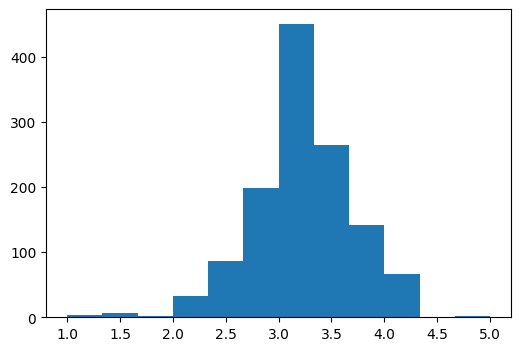

In [7]:
# Оценим визуально распределение целевой переменной
plt.figure(figsize=(6, 4))
plt.hist(df_train.Rating, bins=12)
plt.show()

В целом, распределение целевой переменной близко к нормальному. Оставим значения целевой переменной без изменений.

Значение 'Cocoa Percent' - на самом деле числовой признак. Преобразуем его.

In [8]:
df_train['Cocoa Percent'] = df_train['Cocoa Percent'].apply(lambda x: x[:-1]).astype(np.float64)
df_test['Cocoa Percent'] = df_test['Cocoa Percent'].apply(lambda x: x[:-1]).astype(np.float64)

Исследуем данные на избыточность.

In [9]:
# Рассмотрим корреляцию числовых признаков между собой
df_train.loc[:, ['REF', 'Review', 'Cocoa Percent', 'Rating']].corr()

,REF,Review,Cocoa Percent,Rating
REF,1.000000,0.984938,0.045015,0.112792
Review,0.984938,1.000000,0.045322,0.111826
Cocoa Percent,0.045015,0.045322,1.000000,-0.172411
Rating,0.112792,0.111826,-0.172411,1.000000


In [10]:
%%capture
cramersv = am.CramersV(df_train.apply(lambda x: x.astype("category") if x.dtype == "object" else x))
cramersv.fit()

In [11]:
cramersv.matrix

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.771074,0.999651,0.616928,0.603849
Specific Bean Origin,0.771074,1.000000,0.808500,0.907954,0.983537
Company Location,0.999651,0.808500,1.000000,0.291639,0.383244
Bean Type,0.616928,0.907954,0.291639,1.000000,0.388294
Broad Bean Origin,0.603849,0.983537,0.383244,0.388294,1.000000


Итог:
*   'REF' и 'Review' несут одну и ту же информацию;
*   'Specific Bean Origin' и 'Broad Bean Origin' несут одну и ту же информацию.

## Обработка пропусков и выбросов

In [12]:
# Удалим пропуски со значением null
df_train.dropna(inplace=True)

In [13]:
# Определим количество пропусков в столбце 'Bean Type'
df_train.loc[:, 'Bean Type'].value_counts().head()

,count
Bean Type,
,628
Trinitario,284
Criollo,104
Forastero,53
Forastero (Nacional),34


Около половины значений в 'Bean Type' - пропущено. Тем не менее, данный признак является значимым для предсказания. Пропуск можно считать отдельной категорией (Unknown).

Также можно заметить, что категорий довольно много и их можно по смыслу объединить в более общие категории.

Для решения данной задачи используем маппинг.

In [14]:
# Заменим пропуски на 'Unknown'
df_train['Bean Type'] = df_train['Bean Type'].apply(lambda x: 'Unknown' if x.strip() == '' else x)
df_test['Bean Type'] = df_test['Bean Type'].apply(lambda x: 'Unknown' if x.strip() == '' else x)

# Словарь маппинга для разновидностей сорта какао
cacao_map = {
'Criollo': ['Criollo', 'Criollo (Porcelana)', 'Criollo (Amarru)', 'Criollo (Ocumare 77)', 'Criollo (Ocumare 67)',
'Criollo (Ocumare 61)', 'Criollo (Ocumare)', 'Criollo (Wild)', 'Criollo, +'],
'Trinitario': ['Trinitario', 'Trinitario (Amelonado)', 'Trinitario, TCGA', 'Trinitario (85% Criollo)'],
'Forastero': ['Forastero', 'Forastero (Arriba)', 'Forastero (Arriba) ASS', 'Forastero (Arriba) ASSS',
'Forastero (Nacional)', 'Forastero (Parazinho)', 'Forastero (Catongo)', 'Forastero (Amelonado)'],
'Nacional': ['Nacional', 'Nacional (Arriba)'],
'Amazonian': ['Amazon', 'Amazon mix', 'Amazon, ICS'],
'Blend': ['Criollo, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero', 'Forastero, Trinitario',
'Trinitario, Nacional', 'Criollo, Forastero', 'Blend-Forastero,Criollo', 'Blend'],
'Unknown': ['\xa0', 'EET', np.nan]
}

# Функция для маппинга разновидностей сорта какао
def map_cacao_type(value):
    for category, variants in cacao_map.items():
        if value in variants:
            return category
    return value

df_train['Bean Type'] = df_train['Bean Type'].apply(map_cacao_type)
df_test['Bean Type'] = df_test['Bean Type'].apply(map_cacao_type)

In [15]:
# Оставим только название первого региона в столбце 'Specific Bean Origin' (повышает качество модели)
df_train['Specific Bean Origin'] = df_train['Specific Bean Origin'].apply(lambda x: x.split(',')[0])
df_test['Specific Bean Origin'] = df_test['Specific Bean Origin'].apply(lambda x: x.split(',')[0])

## Построение новых признаков

In [16]:
df_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),Ocumare,508,2010,72.0,Switzerland,3.50,Unknown,Venezuela
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,Unknown,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,Java,32,2006,75.0,France,3.50,Criollo,Indonesia


Вероятно, метки для редких категорий могут повысить качество моделей, основанных на деревьях.

In [17]:
# Создадим список часто встречающихся категорий в 'Bean Type'
top_bean_type_cat = df_train['Bean Type'].value_counts()
top_bean_type_cat = top_bean_type_cat[top_bean_type_cat > 5].index

# Добавим метки редких категорий 'Bean Type' в трейне
df_train['Bean Type Rare'] = 1
df_train.loc[df_train['Bean Type'].isin(top_bean_type_cat), 'Bean Type Rare'] = 0

# Аналогично в тесте
df_test['Bean Type Rare'] = 1
df_test.loc[df_test['Bean Type'].isin(top_bean_type_cat), 'Bean Type Rare'] = 0

Замечание: данный метод эффективен, когда есть несколько крупных выделяющихся категорий, число наблюдений для которых сильно больше числа наблюдений для малых категорий, которые помечаются флагом 'Rare' как шумовые.

Добавим кодирование исторического качества для категориальных признаков. Для избежания утечки будем использовать OOF mean encoding.

In [18]:
from sklearn.model_selection import KFold

def mean_target_encoding_oof(train_df, test_df, col, target, n_splits=2, seed=42):
    """
    Возвращает два Series:
      - train_encoded: OOF mean encoding для train (без утечки)
      - test_encoded: mean encoding для test (по всему train)
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    train_encoded = pd.Series(index=train_df.index, dtype=float)

    global_mean = train_df[target].mean()

    for tr_idx, val_idx in kf.split(train_df):
        tr, val = train_df.iloc[tr_idx], train_df.iloc[val_idx]
        means = tr.groupby(col)[target].mean()
        train_encoded.iloc[val_idx] = val[col].map(means).fillna(global_mean)

    # для теста считаем средние по всему train
    full_means = train_df.groupby(col)[target].mean()
    test_encoded = test_df[col].map(full_means).fillna(global_mean)

    return train_encoded, test_encoded

# Кодировка исторического качества для категориальных признаков
df_train["company_rating_mean_oof"], df_test["company_rating_mean_oof"] = \
mean_target_encoding_oof(df_train, df_test, col="Company", target="Rating")

df_train["origin_rating_mean_oof"], df_test["origin_rating_mean_oof"] = \
mean_target_encoding_oof(df_train, df_test, col="Specific Bean Origin", target="Rating")

df_train["bean_type_rating_mean_oof"], df_test["bean_type_rating_mean_oof"] = \
mean_target_encoding_oof(df_train, df_test, col="Bean Type", target="Rating")

Данная мера оказалась эффективной для признаков 'Company', 'Specific Bean Origin' и 'Bean Type'. Однако добавление среднего рейтинга для 'Company Location' понизило качество модели. Это можно объяснить тем фактом, что в одной стране может производиться шоколад как с высоким рейтингом, так и с низким. По этой причине средний рейтинг для 'Company Location' скорее добавляет шумы.

In [19]:
df_train['Review'].describe()

,Review
count,1253.000000
mean,2012.383879
std,2.924551
min,2006.000000
25%,2010.000000
50%,2013.000000
75%,2015.000000
max,2017.000000


У нас имеется временной идентификатор 'REF'. Из признака 'Review' мы точно знаем, что записи велись в течении 12 лет. При помощи разбиения 'REF' на бины можно попробовать закодировать сезонную информацию. Это может иметь значение для сельскохозяйственной продукции.

In [20]:
# Год точно известен
df_train['Year'] = df_train['Review'].astype(str)
df_test['Year'] = df_test['Review'].astype(str)

# Кодирование месяца при помощи разбиения 'REF' на бины
df_train['Month'] = pd.cut(df_train['REF'], bins=144, labels=False).apply(lambda x: x%12).astype(str)
df_test['Month'] = pd.cut(df_test['REF'], bins=144, labels=False).apply(lambda x: x%12).astype(str)

Оба новых признака будут рассматриваться как категориальные. Кодирование месяца может быть не совсем точным, но добавление данного признака повышает качество модели.

Качество продукции может варьироваться в зависимости от года и месяца. Добавим дополнительно признаки, кодирующие среднее значение рейтинга для месяца и года.

In [21]:
# Также используем OOF mean encoding
df_train["year_rating_mean_oof"], df_test["year_rating_mean_oof"] = \
mean_target_encoding_oof(df_train, df_test, col="Year", target="Rating")

df_train["month_rating_mean_oof"], df_test["month_rating_mean_oof"] = \
mean_target_encoding_oof(df_train, df_test, col="Month", target="Rating")

## Отбор признаков

Удалим признаки 'Review' и 'Broad Bean Origin', так как они избыточны (есть другие признаки, несущие ту же информацию).

In [22]:
df_train.drop(['Review', 'Broad Bean Origin'], axis=1, inplace=True)
df_test.drop(['Review', 'Broad Bean Origin'], axis=1, inplace=True)

In [23]:
df_train.head()

,Company,Specific Bean Origin,REF,Cocoa Percent,Company Location,Rating,Bean Type,Bean Type Rare,company_rating_mean_oof,origin_rating_mean_oof,bean_type_rating_mean_oof,Year,Month,year_rating_mean_oof,month_rating_mean_oof
0,Willie's Cacao,Rio Caribe,457,72.0,U.K.,3.25,Trinitario,0,3.250000,3.000000,3.317857,2009,9,3.108108,3.100746
1,Beschle (Felchlin),Ocumare,508,72.0,Switzerland,3.50,Unknown,0,3.000000,3.281250,3.126198,2010,1,3.097826,3.270270
2,Dark Forest,Tanzania,1554,70.0,U.S.A.,3.00,Unknown,0,3.250000,3.166667,3.132911,2015,6,3.287946,3.128906
3,Brasstown aka It's Chocolate,Cooproagro,1125,72.0,U.S.A.,3.00,Trinitario,0,3.750000,3.176377,3.205782,2013,10,3.125000,3.072727
4,Pralus,Java,32,75.0,France,3.50,Criollo,0,3.361111,2.750000,3.200820,2006,1,3.197917,3.270270


## Полиномиальные признаки

Выделение матрицы объект-признак.

In [24]:
X_train = df_train.drop('Rating', axis=1)
y_train = df_train.loc[:, 'Rating']
X_test = df_test

Добавление и отбор полиномиальных признаков.

In [25]:
from sklearn.preprocessing import PolynomialFeatures

# выделяем числовые признаки
cat_features = [0, 1, 4, 5, 10, 11]
num_cols = [i for i in range(len(X_test.columns)) if i not in cat_features]
num_cols_labels = X_test.columns[num_cols]
X_num_train = X_train.loc[:, num_cols_labels]
X_num_test = X_test.loc[:, num_cols_labels]

# создаём полиномиальные признаки
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_num_train)
X_poly_test = poly.fit_transform(X_num_test)

# превращаем обратно в DataFrame с понятными названиями
poly_features_train = pd.DataFrame(X_poly_train, columns=poly.get_feature_names_out(num_cols_labels), index=X_train.index).drop(num_cols_labels, axis=1)
poly_features_test = pd.DataFrame(X_poly_test, columns=poly.get_feature_names_out(num_cols_labels), index=X_test.index).drop(num_cols_labels, axis=1)

# объединяем с исходным датафреймом
df_poly = pd.concat([y_train, poly_features_train], axis=1)

# отбираем новые признаки по корреляции с целевой переменной
corrs = df_poly.corr()['Rating'].abs().sort_values(ascending=False)
significant = corrs[corrs > 0.235] # порог подобран вручную

poly_features_train = poly_features_train[significant.index[1:]]
poly_features_test = poly_features_test[significant.index[1:]]

# получаем итоговые датафреймы
X_train = pd.concat([X_train, poly_features_train], axis=1)
X_test = pd.concat([X_test, poly_features_test], axis=1)

## Построение baseline-модели

Базовая модель использовалась для оценки влияния Feature Engineering на качество предсказания.

In [26]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=2000,
    cat_features=cat_features,
    random_seed=42,
    verbose=False
)

model.fit(X_train, y_train)

In [27]:
prediction = model.predict(X_test)
df_test['id'] = np.arange(len(prediction))
df_test['Rating'] = prediction
df_test[['id','Rating']].to_csv("baseline_submission.csv", index=False)

## Обучение CatBoost (Optuna)

Подбор оптимальных гиперпараметров для CatBoost с помощью Optuna.

In [28]:
import optuna
from sklearn.model_selection import cross_val_score

def objective_catboost(trial):

  params = {'iterations': trial.suggest_int('iterations', 750, 2750),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.04, log=True),
            'depth': trial.suggest_int('depth', 3, 9),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 5)}

  score = cross_val_score(CatBoostRegressor(cat_features=cat_features, random_seed=33, verbose=100, **params),
                          X_train, y_train, cv=5, scoring='r2', n_jobs=-1).mean()
  return score

study = optuna.create_study(direction='maximize')
study.optimize(objective_catboost, n_trials=35)

print(f'\n Лучший R2: {study.best_value}')
print(f'\n Лучшие параметры: {study.best_params}')

[I 2025-08-21 12:16:27,703] A new study created in memory with name: no-name-c8b2ef68-c579-46f1-84c0-d70c24baa144
[I 2025-08-21 12:18:27,253] Trial 0 finished with value: 0.20817710681067325 and parameters: {'iterations': 1355, 'learning_rate': 0.004354682715437621, 'depth': 8, 'l2_leaf_reg': 0.0494386091232657}. Best is trial 0 with value: 0.20817710681067325.
[I 2025-08-21 12:19:12,251] Trial 1 finished with value: 0.2216776433262097 and parameters: {'iterations': 1641, 'learning_rate': 0.010027192297908352, 'depth': 5, 'l2_leaf_reg': 2.8629561365348994}. Best is trial 1 with value: 0.2216776433262097.
[I 2025-08-21 12:19:46,025] Trial 2 finished with value: 0.20774156902275792 and parameters: {'iterations': 2661, 'learning_rate': 0.0041784085943832195, 'depth': 3, 'l2_leaf_reg': 0.5205247562345094}. Best is trial 1 with value: 0.2216776433262097.
[I 2025-08-21 12:20:27,118] Trial 3 finished with value: 0.17294238060834782 and parameters: {'iterations': 1351, 'learning_rate': 0.00162


 Лучший R2: 0.24162243112086443

 Лучшие параметры: {'iterations': 2230, 'learning_rate': 0.017658053168226145, 'depth': 4, 'l2_leaf_reg': 1.4718790795830625}


Обучение итоговой модели c подобранными гиперпараметрами.

In [29]:
# Сохраним оптимальные гиперпараметры, найденные при помощи Optuna
final_params = {'iterations': 2741, 'learning_rate': 0.016839579753802833, 'depth': 4, 'l2_leaf_reg': 4.502060979463514}

final_model = CatBoostRegressor(cat_features=cat_features,
                                random_seed=33,
                                verbose=100,
                                **final_params)

final_model.fit(X_train, y_train)

0:	learn: 0.4774312	total: 11.1ms	remaining: 30.5s
100:	learn: 0.4323344	total: 642ms	remaining: 16.8s
200:	learn: 0.4146868	total: 1.25s	remaining: 15.7s
300:	learn: 0.4046899	total: 1.78s	remaining: 14.4s
400:	learn: 0.3976779	total: 2.07s	remaining: 12.1s
500:	learn: 0.3921140	total: 2.29s	remaining: 10.2s
600:	learn: 0.3857065	total: 2.55s	remaining: 9.07s
700:	learn: 0.3804650	total: 2.77s	remaining: 8.07s
800:	learn: 0.3759414	total: 2.99s	remaining: 7.24s
900:	learn: 0.3717603	total: 3.21s	remaining: 6.56s
1000:	learn: 0.3681091	total: 3.45s	remaining: 6s
1100:	learn: 0.3642758	total: 3.67s	remaining: 5.46s
1200:	learn: 0.3606241	total: 3.89s	remaining: 4.99s
1300:	learn: 0.3569409	total: 4.11s	remaining: 4.55s
1400:	learn: 0.3527640	total: 4.35s	remaining: 4.17s
1500:	learn: 0.3483733	total: 4.58s	remaining: 3.78s
1600:	learn: 0.3445453	total: 4.81s	remaining: 3.42s
1700:	learn: 0.3409496	total: 5.03s	remaining: 3.07s
1800:	learn: 0.3372108	total: 5.25s	remaining: 2.74s
1900:	l

Финальное предсказание.

In [30]:
prediction = final_model.predict(X_test)
df_test['id'] = np.arange(len(prediction))
df_test['Rating'] = prediction
df_test[['id','Rating']].to_csv("final_submission.csv", index=False)

## Вывод

Результирующее качество на тесте, которое удалось достичь: $R^{2} = 0.26236$.
В ходе соревнования было применено много подходов, которые повысили качество базовой модели. Среди них выделим следующие:


1. **Снижение числа категорий в признаках при сохранении информативности (маппинг)**\
В данном случае разновидности одного и того же сорта какао объединялись в одну категорию.


2. **Добавление флага 'Rare' для редких категорий**\
Позволяет дополнительно для модели выделить выбросы, но работает только если категория действительно выделяется на фоне остальных в силу своей малочисленности. Т.е. если между крупными и малыми категориями действительно существует **большой скачок** в числе объектов (а **не плавное перетекание**).


3. **Добавление среднего значения для категории с использованием OOF mean encoding**\
Очень эффективная мера, требует использование OOF mean encoding для избежания утечки.


4. **Кодирование сезонной информации при помощи бинирования**\
Имея в распоряжении временной идентификатор базы данных и год, я применил бинирование для того, чтобы закодировать сезонную информацию. Идея следующая: (12 лет) * (12 месяцев в году) = (число бинов). Находим остаток от деления номера бина на 12 - получаем номер месяца. Метод неточный, но он повысил качество модели.


5. **Добавление полиномиальных признаков**\
Числовые признаки были отделены от категориальных, для них были посчитаны полиномиальные признаки, после чего был произведен отбор полиномиальных признаков по корреляции с целевой переменной. Данный метод незначительно повысил качество модели.


6. **Использование Optuna для подбора гиперпараметров**\
Потребовалось несколько запусков, чтобы получить оптимальный набор гиперпараметров. Для оценки качества модели при заданном наборе гиперпараметров метрика считалась по кросс-валидации. Финальная модель обучалась уже на всем тренировочном наборе данных.

Итог: ключевую роль сыграли работа с признаками, Feature Engineering и подбор гиперпараметров.

Ссылка на GitHub: https://github.com/ivanchepkasov5278 .